In [1]:
import json
import numpy as np
import cv2
import datetime
import hashlib
import os
import shutil
from skimage import io
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import pydicom
import typer
from pathlib import Path
from pycocotools.coco import COCO

# notebook tqdm
from tqdm.notebook import tqdm

from tqdm import tqdm

CATEGORIES = ["infarct", "nonischaemic", "insertionpoint"]
USE_DICOM_LEVEL = False
PERCENTILE_WINDOWING = [10,99]

raw_coco_path = r"E:\Dropbox\Work\Papers\ALGE\data\_annotations.coco.json"
src_dicom_root =r"E:\Dropbox\Work\Papers\ALGE\data"
mosaic_root = r"E:\Dropbox\Work\Papers\ALGE\data\png"
output_root = r"E:\Dropbox\Work\Papers\ALGE\data\data_processed"
prop_val: float = 0.25
prop_test: float = 0.25


In [2]:
def load_json(path):
    with open(path) as file:
        return json.load(file)


def hash_to_float(name):
    return int(hashlib.sha256(name.encode('utf-8')).hexdigest(), 16) % (10**8) / (10**8)


def init_coco_structure():
    return {
        "info": {
            "description": "LGE probability dataset",
            "url": "www.aid.mr",
            "version": "1.0",
            "year": datetime.datetime.now().year,
            "date_created": datetime.datetime.now().isoformat()
        },
        "licenses": [],
        "categories": [{"id": i + 1, "name": cat, "supercategory": ""} for i, cat in enumerate(CATEGORIES)],
        "images": [],
        "annotations": []
    }

def metadata_window(image_data: np.ndarray,
                    window_center: float,
                    window_width: float,
                    as_uint8: bool):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2

    image_data[image_data < img_min] = img_min
    image_data[image_data > img_max] = img_max

    # Normalize
    image_data = (image_data - img_min) / (img_max - img_min)

    if as_uint8:
        return (image_data * 255).astype(np.uint8)
    else:
        return image_data

def load_image_from_dicom(dcm_path_or_dcm, as_uint8=True):
    if isinstance(dcm_path_or_dcm, pydicom.FileDataset):
        dicom = dcm_path_or_dcm
    else:
        dicom = pydicom.dcmread(dcm_path_or_dcm)
        
    if USE_DICOM_LEVEL:
        wc, ww = dicom.WindowCenter, dicom.WindowWidth
        img = metadata_window(dicom.pixel_array, wc, ww, as_uint8=as_uint8)  # Window after interpolation to stop spilling out of 0/1

    else:
        img = dicom.pixel_array
        img_min, img_max = np.percentile(img, PERCENTILE_WINDOWING)
        img = img - img_min
        img = img / (img_max - img_min)
        img = np.clip(img, 0, 1)
        if as_uint8:
            img = (img*255).astype(np.uint8)
        
    return img

In [3]:
coco_data_mosaic = load_json(raw_coco_path)

train_data = init_coco_structure()
val_data = init_coco_structure()
test_data = init_coco_structure()
train_data['licenses'], val_data['licenses'], test_data['licenses'] = coco_data_mosaic.get('licenses', []), coco_data_mosaic.get('licenses', []), coco_data_mosaic.get('licenses', [])

# Adjust category mapping
category_mapping = {cat["id"]: (cat["name"].split("_")[0], int(cat["name"].split("_")[-1])) for cat in coco_data_mosaic["categories"] if "_" in cat["name"]}

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


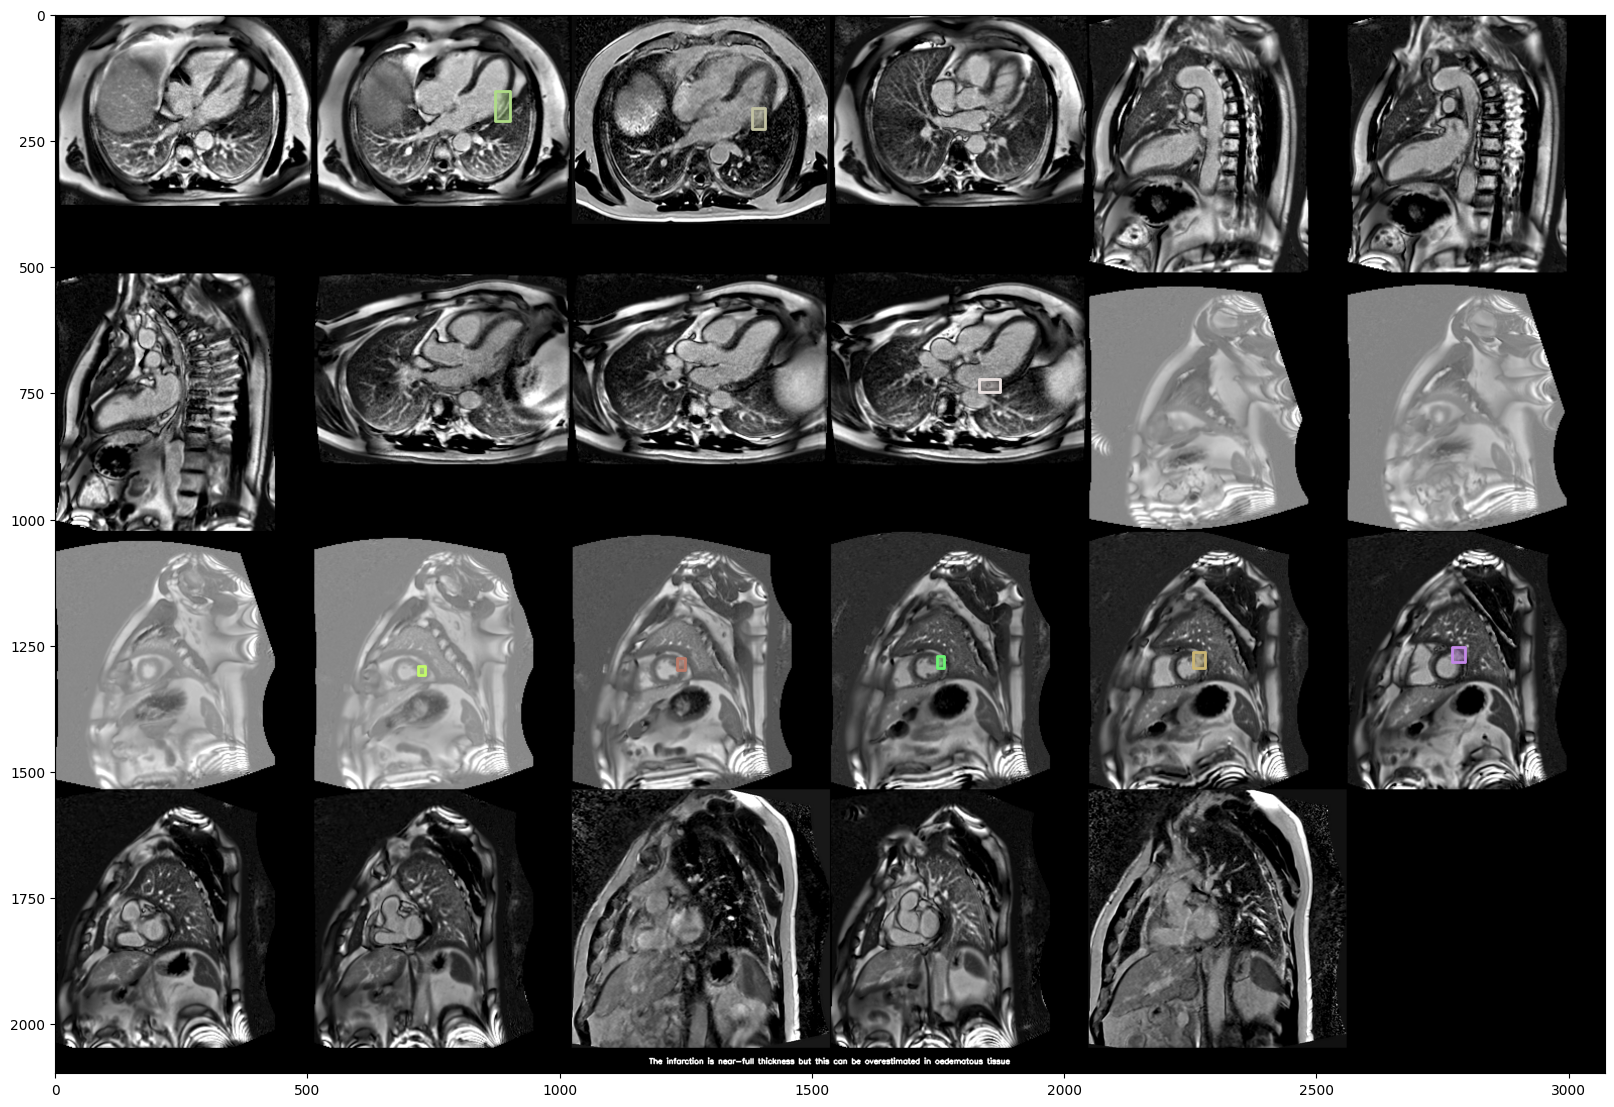

In [4]:
coco_tile = COCO(raw_coco_path)
image_ids = coco_tile.getImgIds()
image_data = coco_tile.loadImgs(image_ids[3])[0]  # Load the first image info
annIds = coco_tile.getAnnIds(imgIds=image_data['id'], iscrowd=None)
anns = coco_tile.loadAnns(annIds)
mosaic_png_path = os.path.join(mosaic_root, image_data['file_name'].split("_png")[0] + ".png")
image = io.imread(os.path.join(mosaic_png_path))
# show image in notebook
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')
coco_tile.showAnns(anns, draw_bbox=True)

In [6]:
# For each fold, create a list of pngs - their index in the list we can then use as image ID
image_ids_by_png_by_fold = defaultdict(list)

# Iterate over each image in the raw COCO data
for image in tqdm(coco_data_mosaic["images"]):
    
    png_name = image["file_name"].split("_png")[0] + ".png"
    train_val_test = "test" if (hash_value := hash_to_float(png_name)) < prop_test else "val" if hash_value < prop_test + prop_val else "train"
    
    current_data = train_data if train_val_test == "train" else val_data if train_val_test == "val" else test_data
    
    mosaic_json_path = os.path.join(mosaic_root, png_name.split(".png")[0] + ".json")
    coords_data = load_json(mosaic_json_path)
    annotations_for_image = [annotation for annotation in coco_data_mosaic["annotations"] if annotation["image_id"] == image["id"]]
    # print(f"Found {len(annotations_for_image)} annotations for image {image['file_name']}")
    for annotation in annotations_for_image:
        category_name, confidence = category_mapping[annotation["category_id"]]
        recoded_category_id = CATEGORIES.index(category_name) + 1
        # print(f"Annotation: {category_name} with confidence {confidence} -> {recoded_category_id}")
        for dcm_rel_path, tile_coords in coords_data["coords"].items():
            dcm_full_path = os.path.join(src_dicom_root, dcm_rel_path)
            img = load_image_from_dicom(dcm_full_path, as_uint8=True)

            start_y_tile, start_x_tile = tile_coords["start"]
            end_y_tile, end_x_tile = tile_coords["end"]
            
            scale_factor_x = img.shape[1] / (end_x_tile - start_x_tile)
            scale_factor_y = img.shape[0] / (end_y_tile - start_y_tile)
            # Check are within a 1% tolerance
            assert abs(scale_factor_x - scale_factor_y) < 0.01, f"Scale factors are not equal: {scale_factor_x}, {scale_factor_y}"
            
            if (start_x_tile <= annotation["bbox"][0] < end_x_tile) and (start_y_tile <= annotation["bbox"][1] < end_y_tile):
                # print('valid')
                # Need to offset the coordinates by the start of the tile, and then within the tile rescale
                new_x_offset = annotation["bbox"][0] - start_x_tile
                new_y_offset = annotation["bbox"][1] - start_y_tile
                
                new_x = new_x_offset * scale_factor_x
                new_y = new_y_offset * scale_factor_y
                
                old_width = annotation["bbox"][2]
                old_height = annotation["bbox"][3]
                
                new_width = old_width * scale_factor_x
                new_height = old_height * scale_factor_y
                
                # print(f"{start_y_tile}, {start_x_tile} : {end_y_tile}, {end_x_tile}")
                # print(f"Scales: {scale_factor_x}, {scale_factor_y}")
                # print(f"{annotation['bbox'][1]}, {annotation['bbox'][0]} -> {new_y}, {new_x}")
                # print(f"{annotation['bbox'][3]}, {annotation['bbox'][2]} -> {new_height}, {new_width}")
                
                png_path_rel = (os.path.splitext(dcm_rel_path)[0] + ".png").replace('\\', '/')

                if png_path_rel in image_ids_by_png_by_fold[train_val_test]:
                    image_id = image_ids_by_png_by_fold[train_val_test].index(png_path_rel)
                else:
                    image_id = len(train_data["images"] if train_val_test == "train" else val_data["images"] if train_val_test == "val" else test_data["images"])
                    image_ids_by_png_by_fold[train_val_test].append(png_path_rel)
                    
                    new_image_entry = {
                        "id": image_id,
                        "file_name": png_path_rel,
                        "dcm_name": dcm_rel_path,
                        "height": img.shape[0],
                        "width": img.shape[1],
                        "date_captured": image["date_captured"]
                    }
                    current_data["images"].append(new_image_entry)
                    
                    png_path_full = os.path.join(output_root, train_val_test, png_path_rel)
                    
                    # write img to the png path
                    os.makedirs(os.path.dirname(png_path_full), exist_ok=True)
                    cv2.imwrite(png_path_full, img)
                
                new_annotation = {
                    "id": len(current_data["annotations"]),
                    "image_id": image_id,
                    "category_id": recoded_category_id,
                    "bbox": [new_x, new_y, new_width, new_height],
                    "area": annotation["area"],
                    "segmentation": annotation["segmentation"],
                    "iscrowd": annotation["iscrowd"],
                    "confidence": confidence
                }
                
                current_data["annotations"].append(new_annotation)
            
# Write out to new JSON files
json_root = os.path.join(output_root, "annotations")
os.makedirs(json_root, exist_ok=True)
with open(os.path.join(json_root, "train.json"), "w") as train_outfile:
    json.dump(train_data, train_outfile, indent=4)
with open(os.path.join(json_root, "val.json"), "w") as val_outfile:
    json.dump(val_data, val_outfile, indent=4)
with open(os.path.join(json_root, "test.json"), "w") as test_outfile:
    json.dump(test_data, test_outfile, indent=4)

  0%|          | 0/30 [00:00<?, ?it/s]

Found 7 annotations for image RYJ10347271_png.rf.631c0ba1495268ce9956c7e41f4c11b5.jpg


  3%|▎         | 1/30 [00:00<00:23,  1.25it/s]

Found 14 annotations for image RYJ10387000_png.rf.6d9a37c7ad5137824afb11b169d272f4.jpg


  7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

Found 10 annotations for image RYJ10290285_png.rf.8dc4c4f3fb7302b39aea5811481b5b17.jpg


 10%|█         | 3/30 [00:02<00:27,  1.01s/it]

Found 8 annotations for image RYJ10396220_png.rf.5399fb52023ebdc52dffe3ee69dd30ac.jpg


 13%|█▎        | 4/30 [00:03<00:21,  1.22it/s]

Found 3 annotations for image RYJ10309932_png.rf.656d4f68d0f767392580b3982522fee6.jpg


 17%|█▋        | 5/30 [00:03<00:16,  1.52it/s]

Found 10 annotations for image RYJ10320390_png.rf.6036e2f881f986d153a03ea80bb45c94.jpg


 20%|██        | 6/30 [00:04<00:17,  1.36it/s]

Found 25 annotations for image RYJ10085230_png.rf.64e1a79450ba8495febe0226ee117c29.jpg


 23%|██▎       | 7/30 [00:06<00:25,  1.13s/it]

Found 9 annotations for image RYJ10336969_png.rf.09f07542682038beb33f1b2c10e43688.jpg


 27%|██▋       | 8/30 [00:06<00:19,  1.15it/s]

Found 21 annotations for image RYJ10268425_png.rf.93cee8a5f1cd1580db1139f21c73da03.jpg


 30%|███       | 9/30 [00:10<00:35,  1.67s/it]

Found 4 annotations for image RYJ10351926_png.rf.0dc54d87f34b3ff6d56896849356cf84.jpg


 33%|███▎      | 10/30 [00:10<00:25,  1.28s/it]

Found 17 annotations for image RYJ10071515_png.rf.9b52b6aefa1264d90acded970cf1a17c.jpg


 37%|███▋      | 11/30 [00:12<00:24,  1.27s/it]

Found 8 annotations for image RYJ10201927_png.rf.7bf670468d16c6cf8353ec3b4066bf7c.jpg


 40%|████      | 12/30 [00:12<00:18,  1.05s/it]

Found 11 annotations for image RYJ10152269_png.rf.41681603a6eedc51eaf61e691abb15c7.jpg


 43%|████▎     | 13/30 [00:13<00:15,  1.09it/s]

Found 9 annotations for image RYJ10287937_png.rf.4d81148ef3fcb02bc067a718f0471178.jpg


 47%|████▋     | 14/30 [00:13<00:13,  1.16it/s]

Found 6 annotations for image RYJ10172603_png.rf.106953d66dc5924529e8a6ae72308412.jpg


 50%|█████     | 15/30 [00:14<00:10,  1.44it/s]

Found 12 annotations for image RYJ10196817_png.rf.6ffc60ed262d719e56941500893c2076.jpg


 53%|█████▎    | 16/30 [00:15<00:10,  1.31it/s]

Found 11 annotations for image RYJ10343069_png.rf.2d708b2d6c0066af1e3e142c62f6831b.jpg


 57%|█████▋    | 17/30 [00:17<00:14,  1.14s/it]

Found 12 annotations for image RYJ10333852_png.rf.04d66076054e8c0ce9c98c8fa6a92709.jpg


 60%|██████    | 18/30 [00:17<00:11,  1.09it/s]

Found 24 annotations for image RYJ10010848_png.rf.16d6d43f4efb21cfaec99b11648b314c.jpg


 67%|██████▋   | 20/30 [00:20<00:10,  1.06s/it]

Found 2 annotations for image RYJ10177796_png.rf.8533b014ab79dc89e6f85aa216e8048a.jpg
Found 33 annotations for image RYJ10296321_png.rf.d7b8b69c44b82ec28367c61fe6e6b228.jpg


 70%|███████   | 21/30 [00:25<00:21,  2.40s/it]

Found 40 annotations for image RYJ10230603_png.rf.973f74e06390bbe444755f37a942c99b.jpg


 73%|███████▎  | 22/30 [00:31<00:26,  3.31s/it]

Found 0 annotations for image RYJ10234180_png.rf.1d8a31b25cb5ee9cda9efda80096a952.jpg
Found 8 annotations for image RYJ10165028_png.rf.a62a0785ed8875e75e0a84f40fcde87c.jpg


 80%|████████  | 24/30 [00:32<00:11,  1.97s/it]

Found 21 annotations for image RYJ10395578_png.rf.65abac64591ca88d44fe3736591626b4.jpg


 83%|████████▎ | 25/30 [00:33<00:08,  1.79s/it]

Found 13 annotations for image RYJ10209631_png.rf.f9b1a033ad70922e0dac28e718fcb827.jpg


 87%|████████▋ | 26/30 [00:34<00:06,  1.65s/it]

Found 9 annotations for image RYJ10360015_png.rf.f31214096bfe78ead831e699f8012548.jpg


 90%|█████████ | 27/30 [00:36<00:04,  1.56s/it]

Found 7 annotations for image RYJ10296327_png.rf.f32b21092b3789caa8b3a77daef3b251.jpg


 93%|█████████▎| 28/30 [00:36<00:02,  1.30s/it]

Found 12 annotations for image RYJ10305094_png.rf.fe35a23f9e805db042c75a09ab8d05ef.jpg


 97%|█████████▋| 29/30 [00:37<00:01,  1.06s/it]

Found 8 annotations for image RYJ10284840_png.rf.d84a931434a37d3cb34704dfd80173a0.jpg


100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


In [ ]:
#     image_file_name = image["file_name"]
#     hash_value = hash_to_float(image_file_name)
#     train_val_test = "test" if hash_value < prop_test else "val" if hash_value < prop_test + prop_val else "train"
#     mosaic_json_path = os.path.join(mosaic_root, image_file_name.split("_png")[0] + ".json")
# 
#     if os.path.exists(mosaic_json_path):
#         coords_data = load_json(mosaic_json_path)
#         annotations_for_image = [annotation for annotation in coco_data["annotations"] if annotation["image_id"] == image["id"]]
#         for annotation in annotations_for_image:
#             category_name, confidence = category_mapping.get(annotation["category_id"], ("unknown", 100))
#             recoded_category_id = CATEGORIES.index(category_name) + 1
#             for dcm_rel_path, dcm_coords in coords_data["coords"].items():
#                 dcm = pydicom.dcmread(dcm_full_path)
#                 img = load_image_from_dicom(dcm_full_path, as_uint8=True)
#                 start_x_dcm, start_y_dcm = dcm_coords["start"]
#                 end_x_dcm, end_y_dcm = dcm_coords["end"]
#                 if (start_x_dcm <= annotation["bbox"][0] < end_x_dcm) and (start_y_dcm <= annotation["bbox"][1] < end_y_dcm):
#                     new_x = annotation["bbox"][0] - start_x_dcm
#                     new_y = annotation["bbox"][1] - start_y_dcm
#                     new_annotation = {
#                         "id": len(train_data["annotations"] if train_val_test == "train" else val_data["annotations"] if train_val_test == "val" else test_data["annotations"]),
#                         "image_id": len(train_data["images"] if train_val_test == "train" else val_data["images"] if train_val_test == "val" else test_data["images"]),
#                         "category_id": recoded_category_id,
#                         "bbox": [new_x, new_y, annotation["bbox"][2], annotation["bbox"][3]],
#                         "area": annotation["area"],
#                         "segmentation": annotation["segmentation"],
#                         "iscrowd": annotation["iscrowd"],
#                         "confidence": confidence
#                     }
# 
#                     # plot images, overlay annotation (like above) and then break as debugging
#                     dcm_full_path = os.path.join(src_dicom_root, dcm_rel_path)
#                     img = load_image_from_dicom(dcm, as_uint8=True)
#                     plt.figure(figsize=(10, 10))
#                     plt.imshow(img, cmap='gray')
#                     plt.gca().add_patch(matplotlib.patches.Rectangle((new_x, new_y), annotation["bbox"][2], annotation["bbox"][3], linewidth=1, edgecolor='r', facecolor='none'))
#                     plt.show()
# 
#                     current_data = train_data if train_val_test == "train" else val_data if train_val_test == "val" else test_data
#                     current_data["annotations"].append(new_annotation)
# 
#                     if all(img["id"] != new_annotation["image_id"] for img in current_data["images"]):
#                         png_path = (os.path.splitext(dcm_path)[0] + ".png").replace('\\', '/')
#                         new_image_entry = {
#                             "id": new_annotation["image_id"],
#                             "file_name": png_path,
#                             "dcm_name": dcm_rel_path,
#                             "height": end_y_dcm - start_y_dcm,
#                             "width": end_x_dcm - start_x_dcm,
#                             "date_captured": image["date_captured"]
#                         }
#                         current_data["images"].append(new_image_entry)
#     else:
#         raise ValueError(f"Could not find JSON file for image {image_file_name} at {mosaic_json_path}")
# 
# # Write out to new JSON files
# json_path = os.path.join(output_root, "annotations")
# with open(os.path.join(json_path, "train.json"), "w") as train_outfile:
#     json.dump(train_data, train_outfile, indent=4)
# with open(os.path.join(json_path, "val.json"), "w") as val_outfile:
#     json.dump(val_data, val_outfile, indent=4)
# with open(os.path.join(json_path, "test.json"), "w") as test_outfile:
#     json.dump(test_data, test_outfile, indent=4)
# 
# # Write out DICOM files
# dicom_root = os.path.join(output_root, "LGE")
# for ds_name, ds in {'train': train_data,
#                     'val': val_data,
#                     'test': test_data}.items():
#     print(f"{ds_name.upper()}")
#     for img_row in tqdm(ds["images"]):
#         src_path = os.path.join(src_dicom_root, img_row["dcm_name"])
# 
#         dcm = pydicom.dcmread(src_path)
#         # rescale pixels using WindowWidth and WindowLevel
#         img = dcm.pixel_array
#         window_center = dcm.WindowCenter
#         window_width = dcm.WindowWidth
#         img_min = window_center - window_width // 2
#         img_max = window_center + window_width // 2
#         img = (img - img_min) / (img_max - img_min)
#         img = (img * 255).astype('uint8')
# 
#         dest_path = os.path.join(dicom_root, ds_name, img_row["file_name"]).replace('\\', '/')
#         if not os.path.exists(dest_path):
#             os.makedirs(os.path.dirname(dest_path), exist_ok=True)
#             # save img as a png
#             cv2.imwrite(dest_path, img)
